# **Imports**

In [431]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, LabelEncoder
from sklearn.decomposition import PCA


# **Dataset original**

In [432]:
data_path = '../data/' 

cvd_df = pd.read_csv(data_path + 'CVD_cleaned.csv')

cvd_df_processed = cvd_df.copy()

# **Distruibuicao dos dados continuos**

In [433]:
cvd_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

# **2. Data Preparation**

## **Normalização e discretização dos dados**

### **Discretização**

**BMI**

In [434]:
# Definição dos intervalos e rótulos baseados nas classes reais de BMI
bins = [0, 18.5, 25, 30, float('inf')]
labels = ['Magreza', 'Normal', 'Sobrepeso', 'Obesidade']

# Discretização do BMI
cvd_df_processed['BMI_classes'] = pd.cut(cvd_df_processed['BMI'], bins=bins, labels=labels)

# Contagem de valores em cada classe
bmi_classes_summary = cvd_df_processed['BMI_classes'].value_counts()
print(bmi_classes_summary)


BMI_classes
Sobrepeso    109644
Obesidade    104544
Normal        90122
Magreza        4544
Name: count, dtype: int64


**Alcohol_Consumption**

In [435]:
# Criar uma nova coluna para classificar consumo de álcool (Sim/Não)
cvd_df_processed['Alcohol_Consumption_class'] = cvd_df_processed['Alcohol_Consumption'].apply(lambda x: 'Yes' if x > 0 else 'No')

# Contagem de valores em cada classe
alcohol_classes_summary = cvd_df_processed['Alcohol_Consumption_class'].value_counts()
print(alcohol_classes_summary)

Alcohol_Consumption_class
Yes    168592
No     140262
Name: count, dtype: int64


In [436]:
cvd_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   General_Health                308854 non-null  object  
 1   Checkup                       308854 non-null  object  
 2   Exercise                      308854 non-null  object  
 3   Heart_Disease                 308854 non-null  object  
 4   Skin_Cancer                   308854 non-null  object  
 5   Other_Cancer                  308854 non-null  object  
 6   Depression                    308854 non-null  object  
 7   Diabetes                      308854 non-null  object  
 8   Arthritis                     308854 non-null  object  
 9   Sex                           308854 non-null  object  
 10  Age_Category                  308854 non-null  object  
 11  Height_(cm)                   308854 non-null  float64 
 12  Weight_(kg)                   

### **Normalização** 

In [437]:
numerical_cols = cvd_df_processed.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = cvd_df_processed.select_dtypes(include=['object', 'category']).columns


**Variáveis Numéricas**

In [438]:
scaler = MinMaxScaler()

cvd_df_processed[numerical_cols] = scaler.fit_transform(cvd_df_processed[numerical_cols])

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
cvd_df_processed[numerical_cols] = discretizer.fit_transform(cvd_df_processed[numerical_cols])


**Variáveis Categóricas**


In [439]:
# Obter a moda da coluna "Diabetes"
moda_diabetes = cvd_df_processed['Diabetes'].mode()[0]

# Substituir valores que não sejam "Yes" ou "No" pela moda
cvd_df_processed['Diabetes'] = cvd_df_processed['Diabetes'].apply(lambda x: x if x in ['Yes', 'No'] else moda_diabetes)

# Verificar a substituição
print(cvd_df_processed['Diabetes'].value_counts())

Diabetes
No     268683
Yes     40171
Name: count, dtype: int64


In [440]:
cvd_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   General_Health                308854 non-null  object  
 1   Checkup                       308854 non-null  object  
 2   Exercise                      308854 non-null  object  
 3   Heart_Disease                 308854 non-null  object  
 4   Skin_Cancer                   308854 non-null  object  
 5   Other_Cancer                  308854 non-null  object  
 6   Depression                    308854 non-null  object  
 7   Diabetes                      308854 non-null  object  
 8   Arthritis                     308854 non-null  object  
 9   Sex                           308854 non-null  object  
 10  Age_Category                  308854 non-null  object  
 11  Height_(cm)                   308854 non-null  float64 
 12  Weight_(kg)                   

Como referimos do DU, decidimos substituir todos os valores que não pertencem a [Yes, No] pela moda da classe visto que é o valor menos afetado por outliers.

In [441]:
label_mappings = {}

for col in categorical_cols:
    label_encoder = LabelEncoder()
    cvd_df_processed[col] = label_encoder.fit_transform(cvd_df_processed[col].astype(str))  # Codificar coluna
    label_mappings[col] = dict(enumerate(label_encoder.classes_))   # Guardar mapeamento

In [442]:
print("Mapping:", label_mappings)


with open(data_path + 'mapeamento/label_mappings.json', 'w') as file:
    json.dump(label_mappings, file, indent=4)

Mapping: {'General_Health': {0: 'Excellent', 1: 'Fair', 2: 'Good', 3: 'Poor', 4: 'Very Good'}, 'Checkup': {0: '5 or more years ago', 1: 'Never', 2: 'Within the past 2 years', 3: 'Within the past 5 years', 4: 'Within the past year'}, 'Exercise': {0: 'No', 1: 'Yes'}, 'Heart_Disease': {0: 'No', 1: 'Yes'}, 'Skin_Cancer': {0: 'No', 1: 'Yes'}, 'Other_Cancer': {0: 'No', 1: 'Yes'}, 'Depression': {0: 'No', 1: 'Yes'}, 'Diabetes': {0: 'No', 1: 'Yes'}, 'Arthritis': {0: 'No', 1: 'Yes'}, 'Sex': {0: 'Female', 1: 'Male'}, 'Age_Category': {0: '18-24', 1: '25-29', 2: '30-34', 3: '35-39', 4: '40-44', 5: '45-49', 6: '50-54', 7: '55-59', 8: '60-64', 9: '65-69', 10: '70-74', 11: '75-79', 12: '80+'}, 'Smoking_History': {0: 'No', 1: 'Yes'}, 'BMI_classes': {0: 'Magreza', 1: 'Normal', 2: 'Obesidade', 3: 'Sobrepeso'}, 'Alcohol_Consumption_class': {0: 'No', 1: 'Yes'}}


In [443]:
cvd_df_processed.describe()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,...,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,BMI_classes,Alcohol_Consumption_class
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,...,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,2.273278,3.515069,0.775062,0.080850,0.097114,0.096738,0.200422,0.130065,0.327245,0.481321,...,2.307035,0.577632,0.386866,0.405577,0.601767,0.843421,0.273747,0.045623,2.033783,0.545863
std,1.494109,1.019576,0.417542,0.272606,0.296113,0.295602,0.400316,0.336375,0.469208,0.499652,...,0.478837,0.549735,0.523829,0.491004,1.195429,0.949287,0.569946,0.263511,0.839350,0.497893
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000
75%,4.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,1.000000
max,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,4.000000,4.000000,1.000000,4.000000,4.000000,4.000000,4.000000,3.000000,1.000000


In [444]:
# Save the processed DataFrame to a CSV file
cvd_df_processed.to_csv(data_path + 'CVD_normalized_discretized_processed.csv', index=False)


# **Redução do *dataset* em 10% e 20%**

In [445]:
cvd_df_10reduced = cvd_df.sample(frac=0.9, random_state=42)

cvd_df_20reduced = cvd_df.sample(frac=0.8, random_state=42)

In [446]:
cvd_df_10reduced.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000
mean,170.616490,83.589927,28.626311,5.089201,29.837356,15.107026,6.290748
std,10.657907,21.326934,6.517495,8.193109,24.886160,14.927084,8.574025
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,274.420000,99.330000,30.000000,120.000000,128.000000,128.000000


In [447]:
cvd_df_20reduced.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,247083.000000,247083.000000,247083.000000,247083.000000,247083.00000,247083.000000,247083.000000
mean,170.599066,83.543578,28.615848,5.095595,29.83444,15.102472,6.289838
std,10.664740,21.309096,6.510003,8.200305,24.87658,14.912416,8.591095
min,91.000000,24.950000,12.020000,0.000000,0.00000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.00000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.00000,12.000000,4.000000
75%,178.000000,95.250000,31.790000,6.000000,30.00000,20.000000,8.000000
max,241.000000,274.420000,99.330000,30.000000,120.00000,128.000000,128.000000


# Tratamento dos Valores Ausentes

## Estratégia 1: Substituir o valores ausentes pela média dos valores ou pela moda

### Dados ausentes do *dataset* reduzido em 10%

Encontrar os dados ausentes do *dataset* reduzido em 10%

In [448]:
dados_removidos = pd.merge(cvd_df, cvd_df_10reduced, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)

In [449]:
cvd_df_10reduced.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000
mean,170.616490,83.589927,28.626311,5.089201,29.837356,15.107026,6.290748
std,10.657907,21.326934,6.517495,8.193109,24.886160,14.927084,8.574025
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,274.420000,99.330000,30.000000,120.000000,128.000000,128.000000


Substituir os atributos numéricos eliminados por médias e os categóricos pela resposta mais frequente

In [450]:
cvd_df_10reduced_imputed = cvd_df_10reduced.copy()

colunas_numericas = cvd_df_10reduced_imputed.select_dtypes(include=['float64']).columns

for col in colunas_numericas:
    media = cvd_df_10reduced_imputed[col].mean()  # Calcular a média da coluna
    cvd_df_10reduced_imputed[col] = cvd_df_10reduced_imputed[col].fillna(media)  # Substituir valores ausentes pela média

colunas_categoricas = cvd_df_10reduced_imputed.select_dtypes(include=['object']).columns

for col in colunas_categoricas:
    moda = cvd_df_10reduced_imputed[col].mode()[0]  # Calcular a moda da coluna
    cvd_df_10reduced_imputed[col] = cvd_df_10reduced_imputed[col].fillna(moda)  # Substituir valores ausentes pela moda

In [451]:
cvd_df_10reduced_imputed.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000
mean,170.616490,83.589927,28.626311,5.089201,29.837356,15.107026,6.290748
std,10.657907,21.326934,6.517495,8.193109,24.886160,14.927084,8.574025
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,274.420000,99.330000,30.000000,120.000000,128.000000,128.000000


Comparação entre o *dataset* original e o *dataset* reduzido em 10%

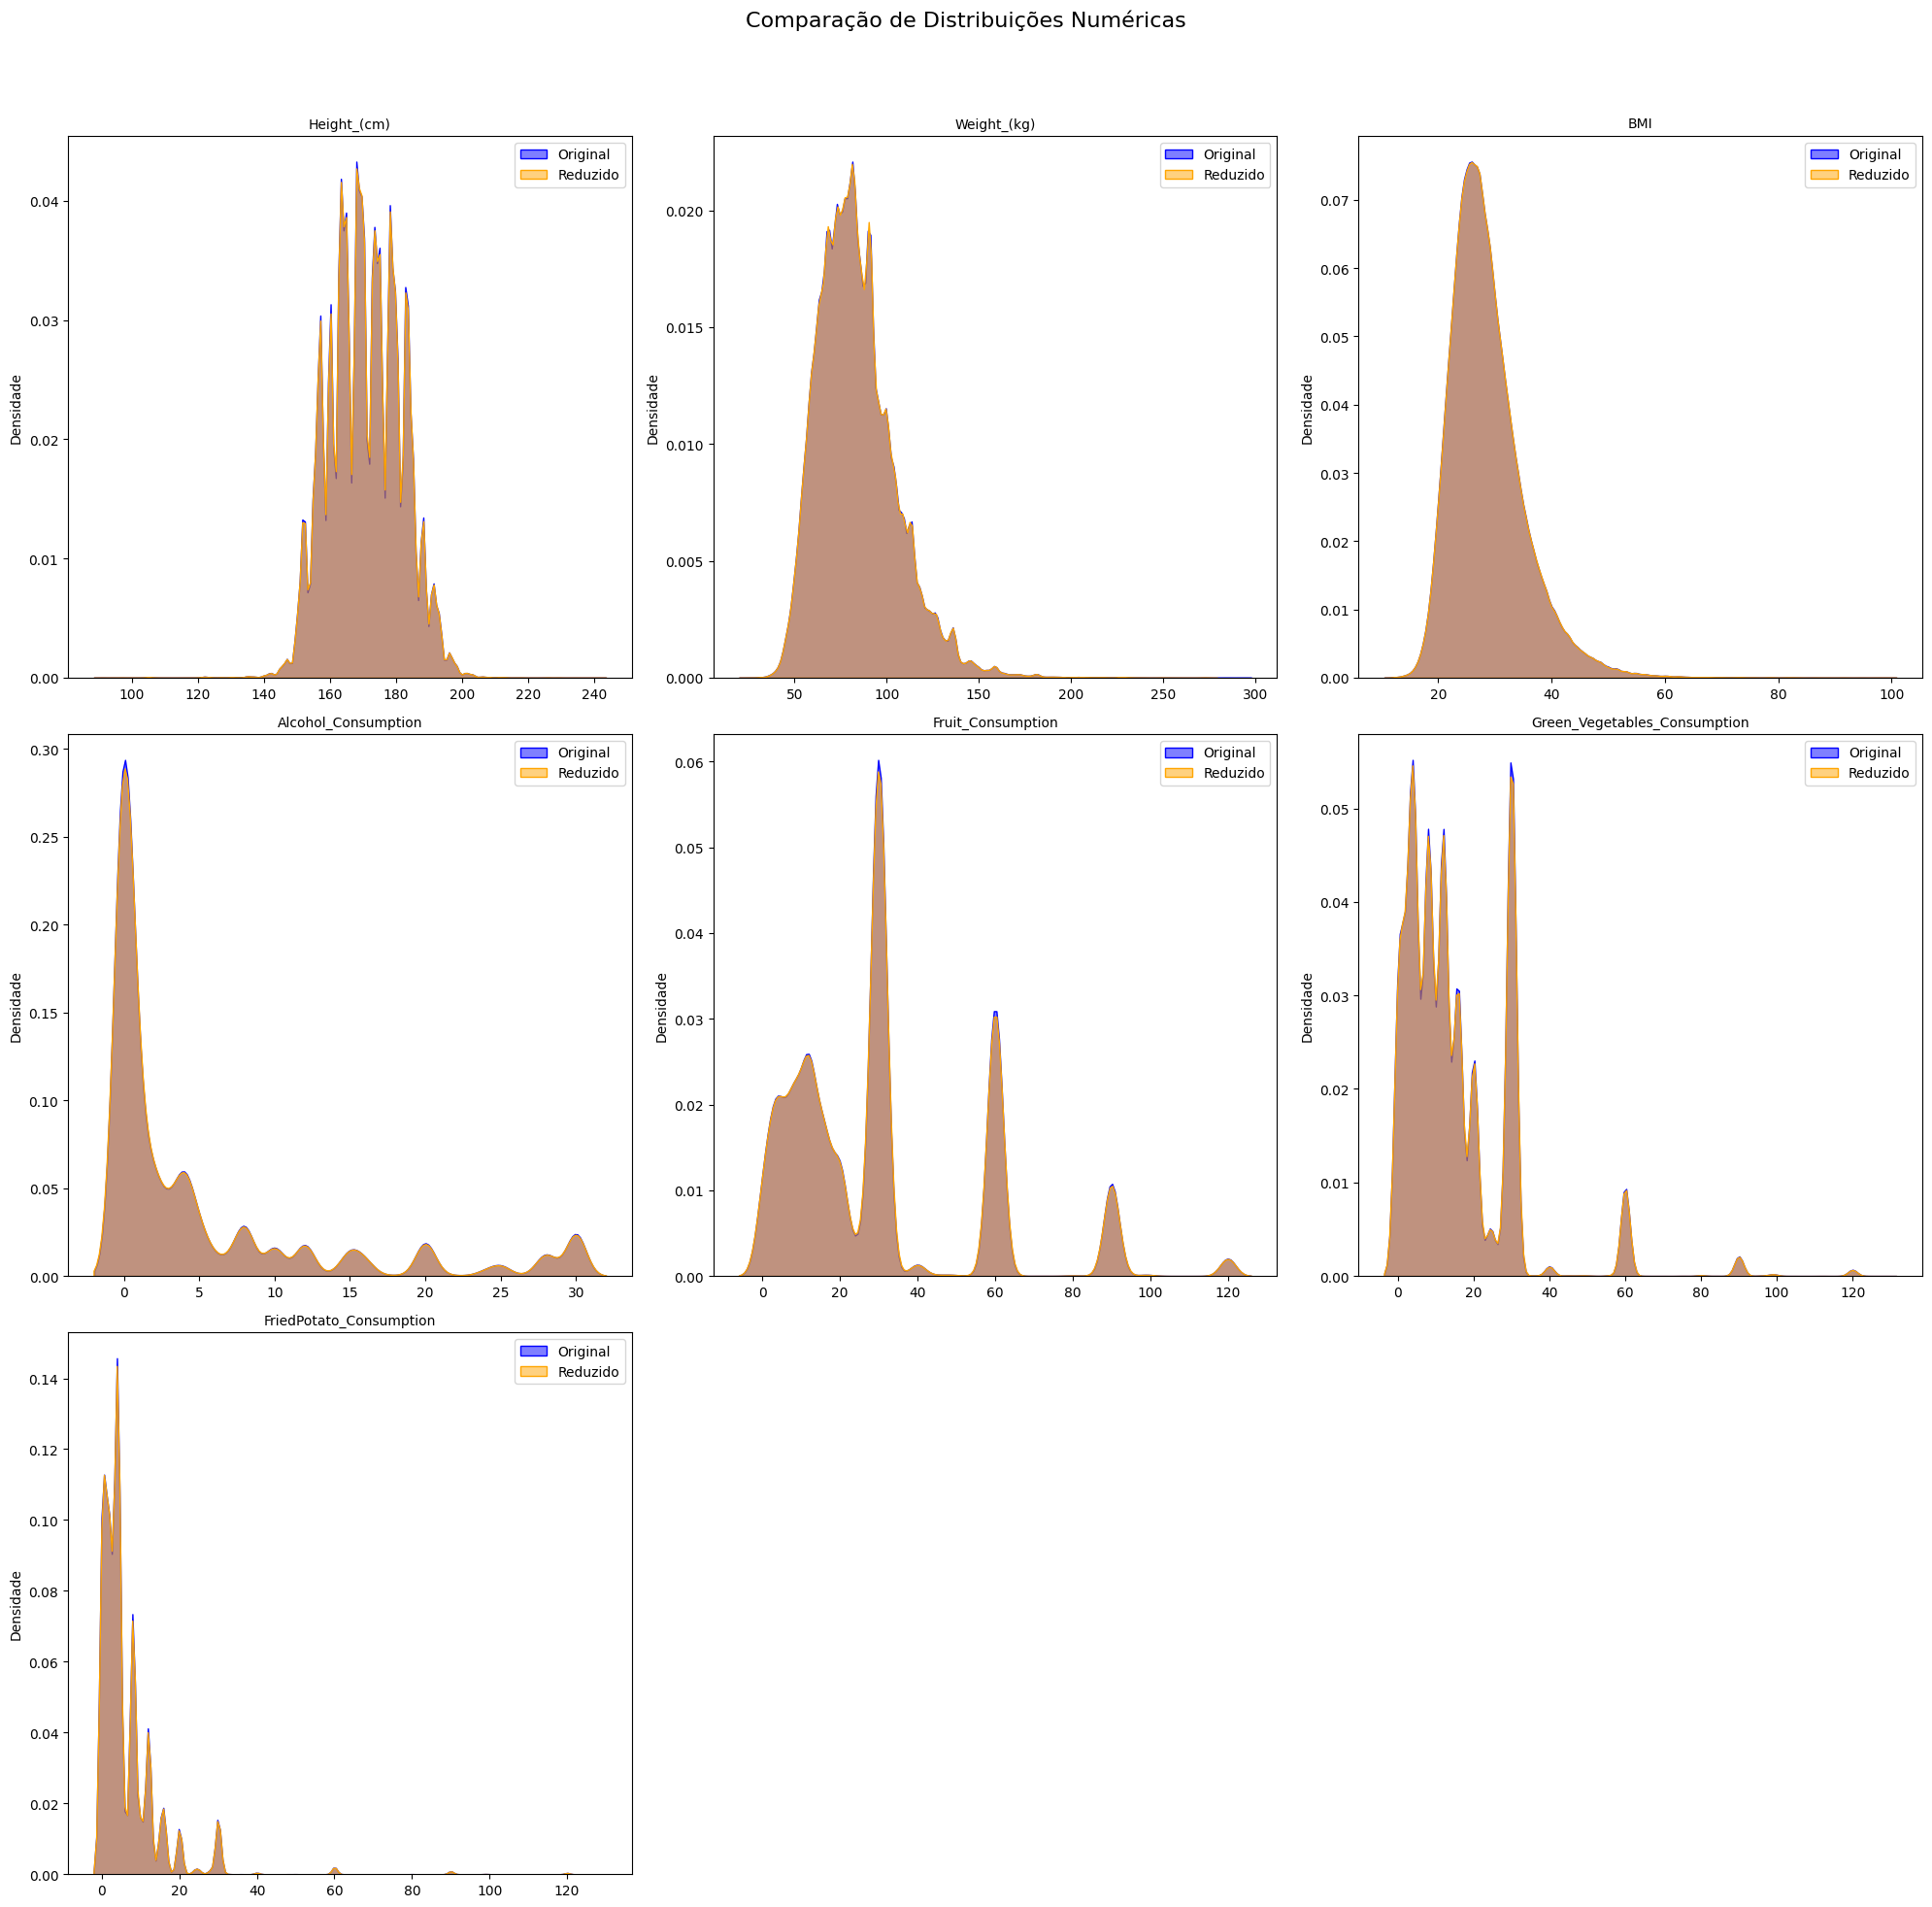

In [452]:
colunas_numericas = cvd_df.select_dtypes(include=['float64']).columns
def comparar_distribuicoes_subplot(df_original, df_reduzido, colunas):
    n_colunas = len(colunas)
    rows, cols = 3, 3  # Layout de subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    fig.suptitle("Comparação de Distribuições Numéricas", fontsize=16)

    axes = axes.flatten()

    for i, col in enumerate(colunas):
        ax = axes[i]

        sns.kdeplot(df_original[col], label='Original', fill=True, color='blue', alpha=0.5, ax=ax)
        sns.kdeplot(df_reduzido[col], label='Reduzido', fill=True, color='orange', alpha=0.5, ax=ax)

        ax.set_title(col, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Densidade')
        ax.legend()

    for j in range(len(colunas), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
comparar_distribuicoes_subplot(cvd_df, cvd_df_10reduced_imputed, colunas_numericas)

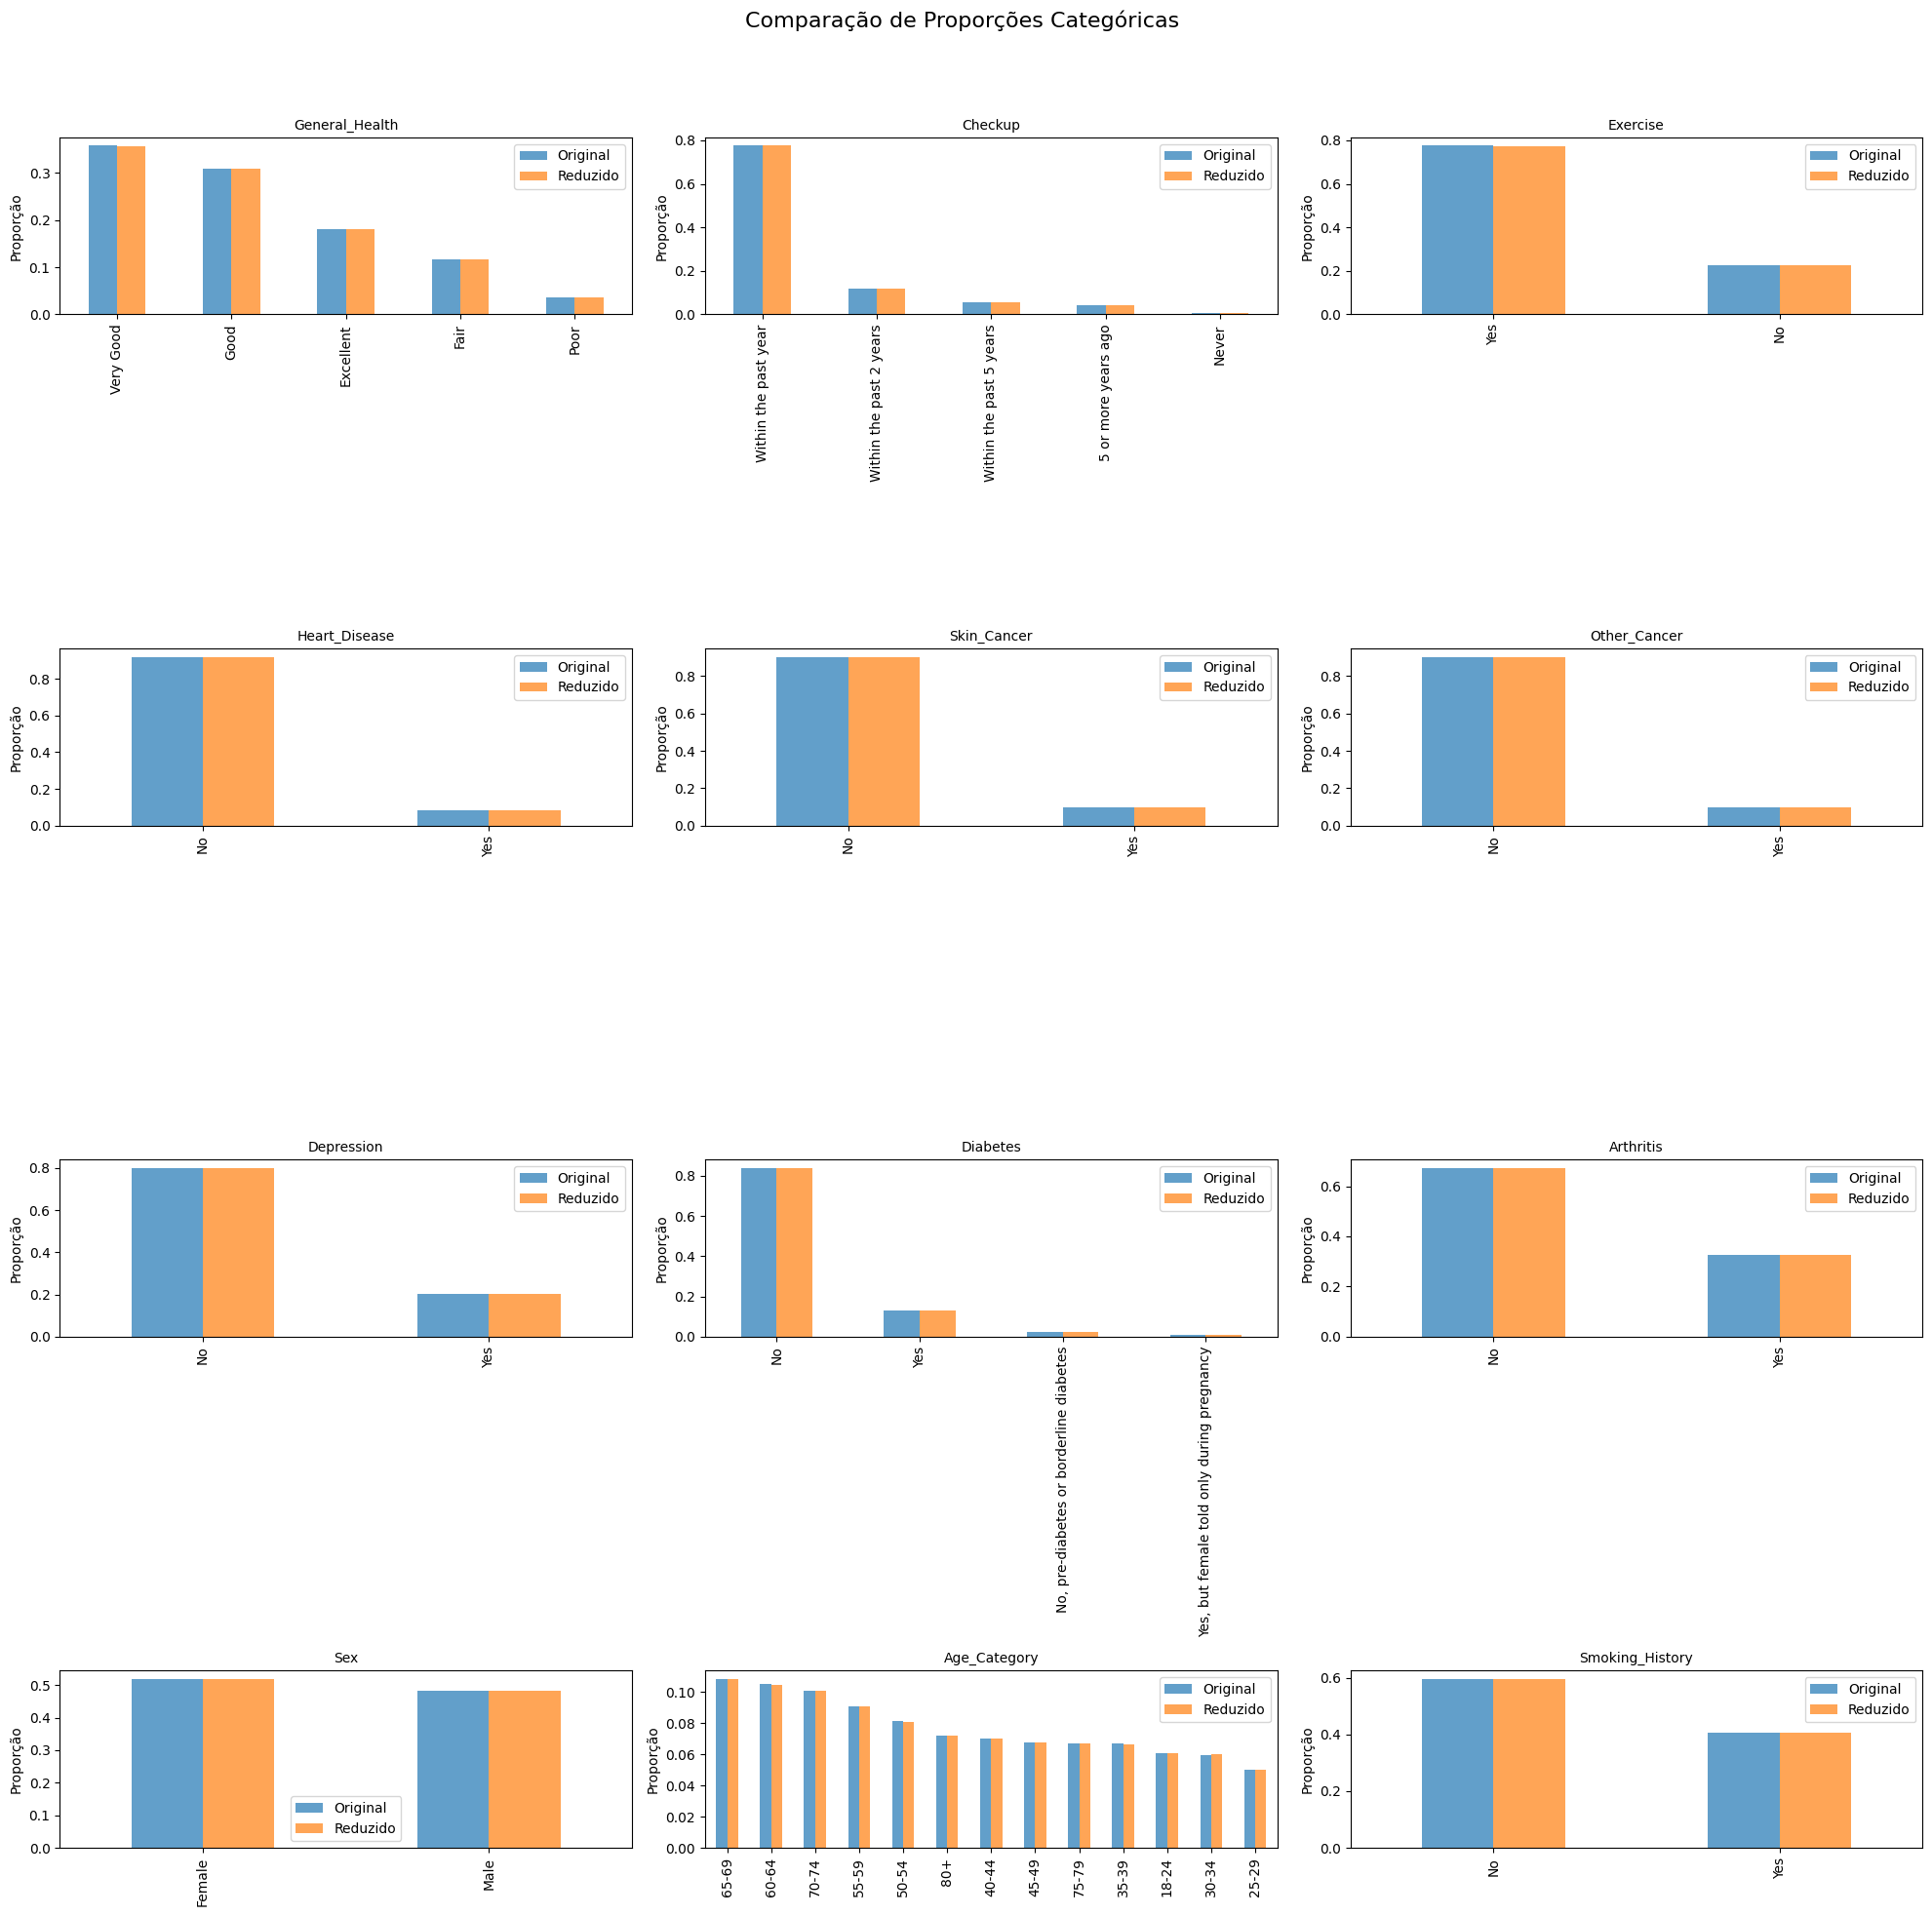

In [453]:
def comparar_proporcoes_subplot(df_original, df_reduzido, colunas):
    n_colunas = len(colunas)
    rows = (n_colunas // 3) + (1 if n_colunas % 3 != 0 else 0)  # Calcular dinamicamente o número de linhas
    cols = 3  

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    fig.suptitle("Comparação de Proporções Categóricas", fontsize=16)

    axes = axes.flatten()

    for i, col in enumerate(colunas):
        ax = axes[i]

        prop_original = df_original[col].value_counts(normalize=True)
        prop_reduzido = df_reduzido[col].value_counts(normalize=True)

        prop_df = pd.DataFrame({'Original': prop_original, 'Reduzido': prop_reduzido})
        prop_df.plot(kind='bar', ax=ax, alpha=0.7)

        ax.set_title(col, fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Proporção')
        ax.legend()

    for j in range(len(colunas), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

colunas_categoricas = cvd_df.select_dtypes(include=['object']).columns

comparar_proporcoes_subplot(cvd_df, cvd_df_10reduced_imputed, colunas_categoricas)


### Análise estatística do dataset reduzido em 10% pela estratégia 1


In [454]:
cvd_df_10reduced_imputed.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000,277969.000000
mean,170.616490,83.589927,28.626311,5.089201,29.837356,15.107026,6.290748
std,10.657907,21.326934,6.517495,8.193109,24.886160,14.927084,8.574025
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,274.420000,99.330000,30.000000,120.000000,128.000000,128.000000


### Dados ausentes do *dataset* reduzido em 20%

In [455]:
dados_removidos = pd.merge(cvd_df, cvd_df_20reduced, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)

colunas_numericas = cvd_df_20reduced.select_dtypes(include=['float64']).columns

for col in colunas_numericas:
    media = cvd_df_20reduced[col].mean()  # Calcular a média da coluna
    cvd_df_10reduced[col] = cvd_df_20reduced[col].fillna(media)  # Substituir valores ausentes pela média

colunas_categoricas = cvd_df_20reduced.select_dtypes(include=['object']).columns

for col in colunas_categoricas:
    moda = cvd_df_20reduced[col].mode()[0]  # Calcular a moda da coluna
    cvd_df_20reduced[col] = cvd_df_20reduced[col].fillna(moda)  # Substituir valores ausentes pela moda


cvd_df_20reduced_imputed = cvd_df_20reduced.copy()

colunas_numericas = cvd_df_10reduced_imputed.select_dtypes(include=['float64']).columns

for col in colunas_numericas:
    media = cvd_df_20reduced_imputed[col].mean()  # Calcular a média da coluna
    cvd_df_20reduced_imputed[col] = cvd_df_20reduced_imputed[col].fillna(media)  # Substituir valores ausentes pela média

colunas_categoricas = cvd_df_10reduced_imputed.select_dtypes(include=['object']).columns

for col in colunas_categoricas:
    moda = cvd_df_10reduced_imputed[col].mode()[0]  # Calcular a moda da coluna
    cvd_df_20reduced_imputed[col] = cvd_df_20reduced_imputed[col].fillna(moda)  # Substituir valores ausentes pela moda






### Análise estatística do dataset reduzido em 20% pela estratégia 1


In [456]:
cvd_df_20reduced_imputed.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,247083.000000,247083.000000,247083.000000,247083.000000,247083.00000,247083.000000,247083.000000
mean,170.599066,83.543578,28.615848,5.095595,29.83444,15.102472,6.289838
std,10.664740,21.309096,6.510003,8.200305,24.87658,14.912416,8.591095
min,91.000000,24.950000,12.020000,0.000000,0.00000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.00000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.00000,12.000000,4.000000
75%,178.000000,95.250000,31.790000,6.000000,30.00000,20.000000,8.000000
max,241.000000,274.420000,99.330000,30.000000,120.00000,128.000000,128.000000


## Estratégia 2: Remoção de linhas com valores ausentes


### Dados ausentes do *dataset* reduzido em 10%

Encontrar os dados ausentes do *dataset* reduzido em 10%

In [457]:
# Identificar índices das linhas ausentes no DataFrame reduzido
indices_removidos = pd.merge(
    cvd_df.assign(_original_index=cvd_df.index),
    cvd_df_10reduced,
    how="left",
    indicator=True
).query('_merge == "left_only"')['_original_index']


cvd_df_10reduced2 = cvd_df.drop(indices_removidos)


Comparação entre o *dataset* original e o *dataset* reduzido em 10%

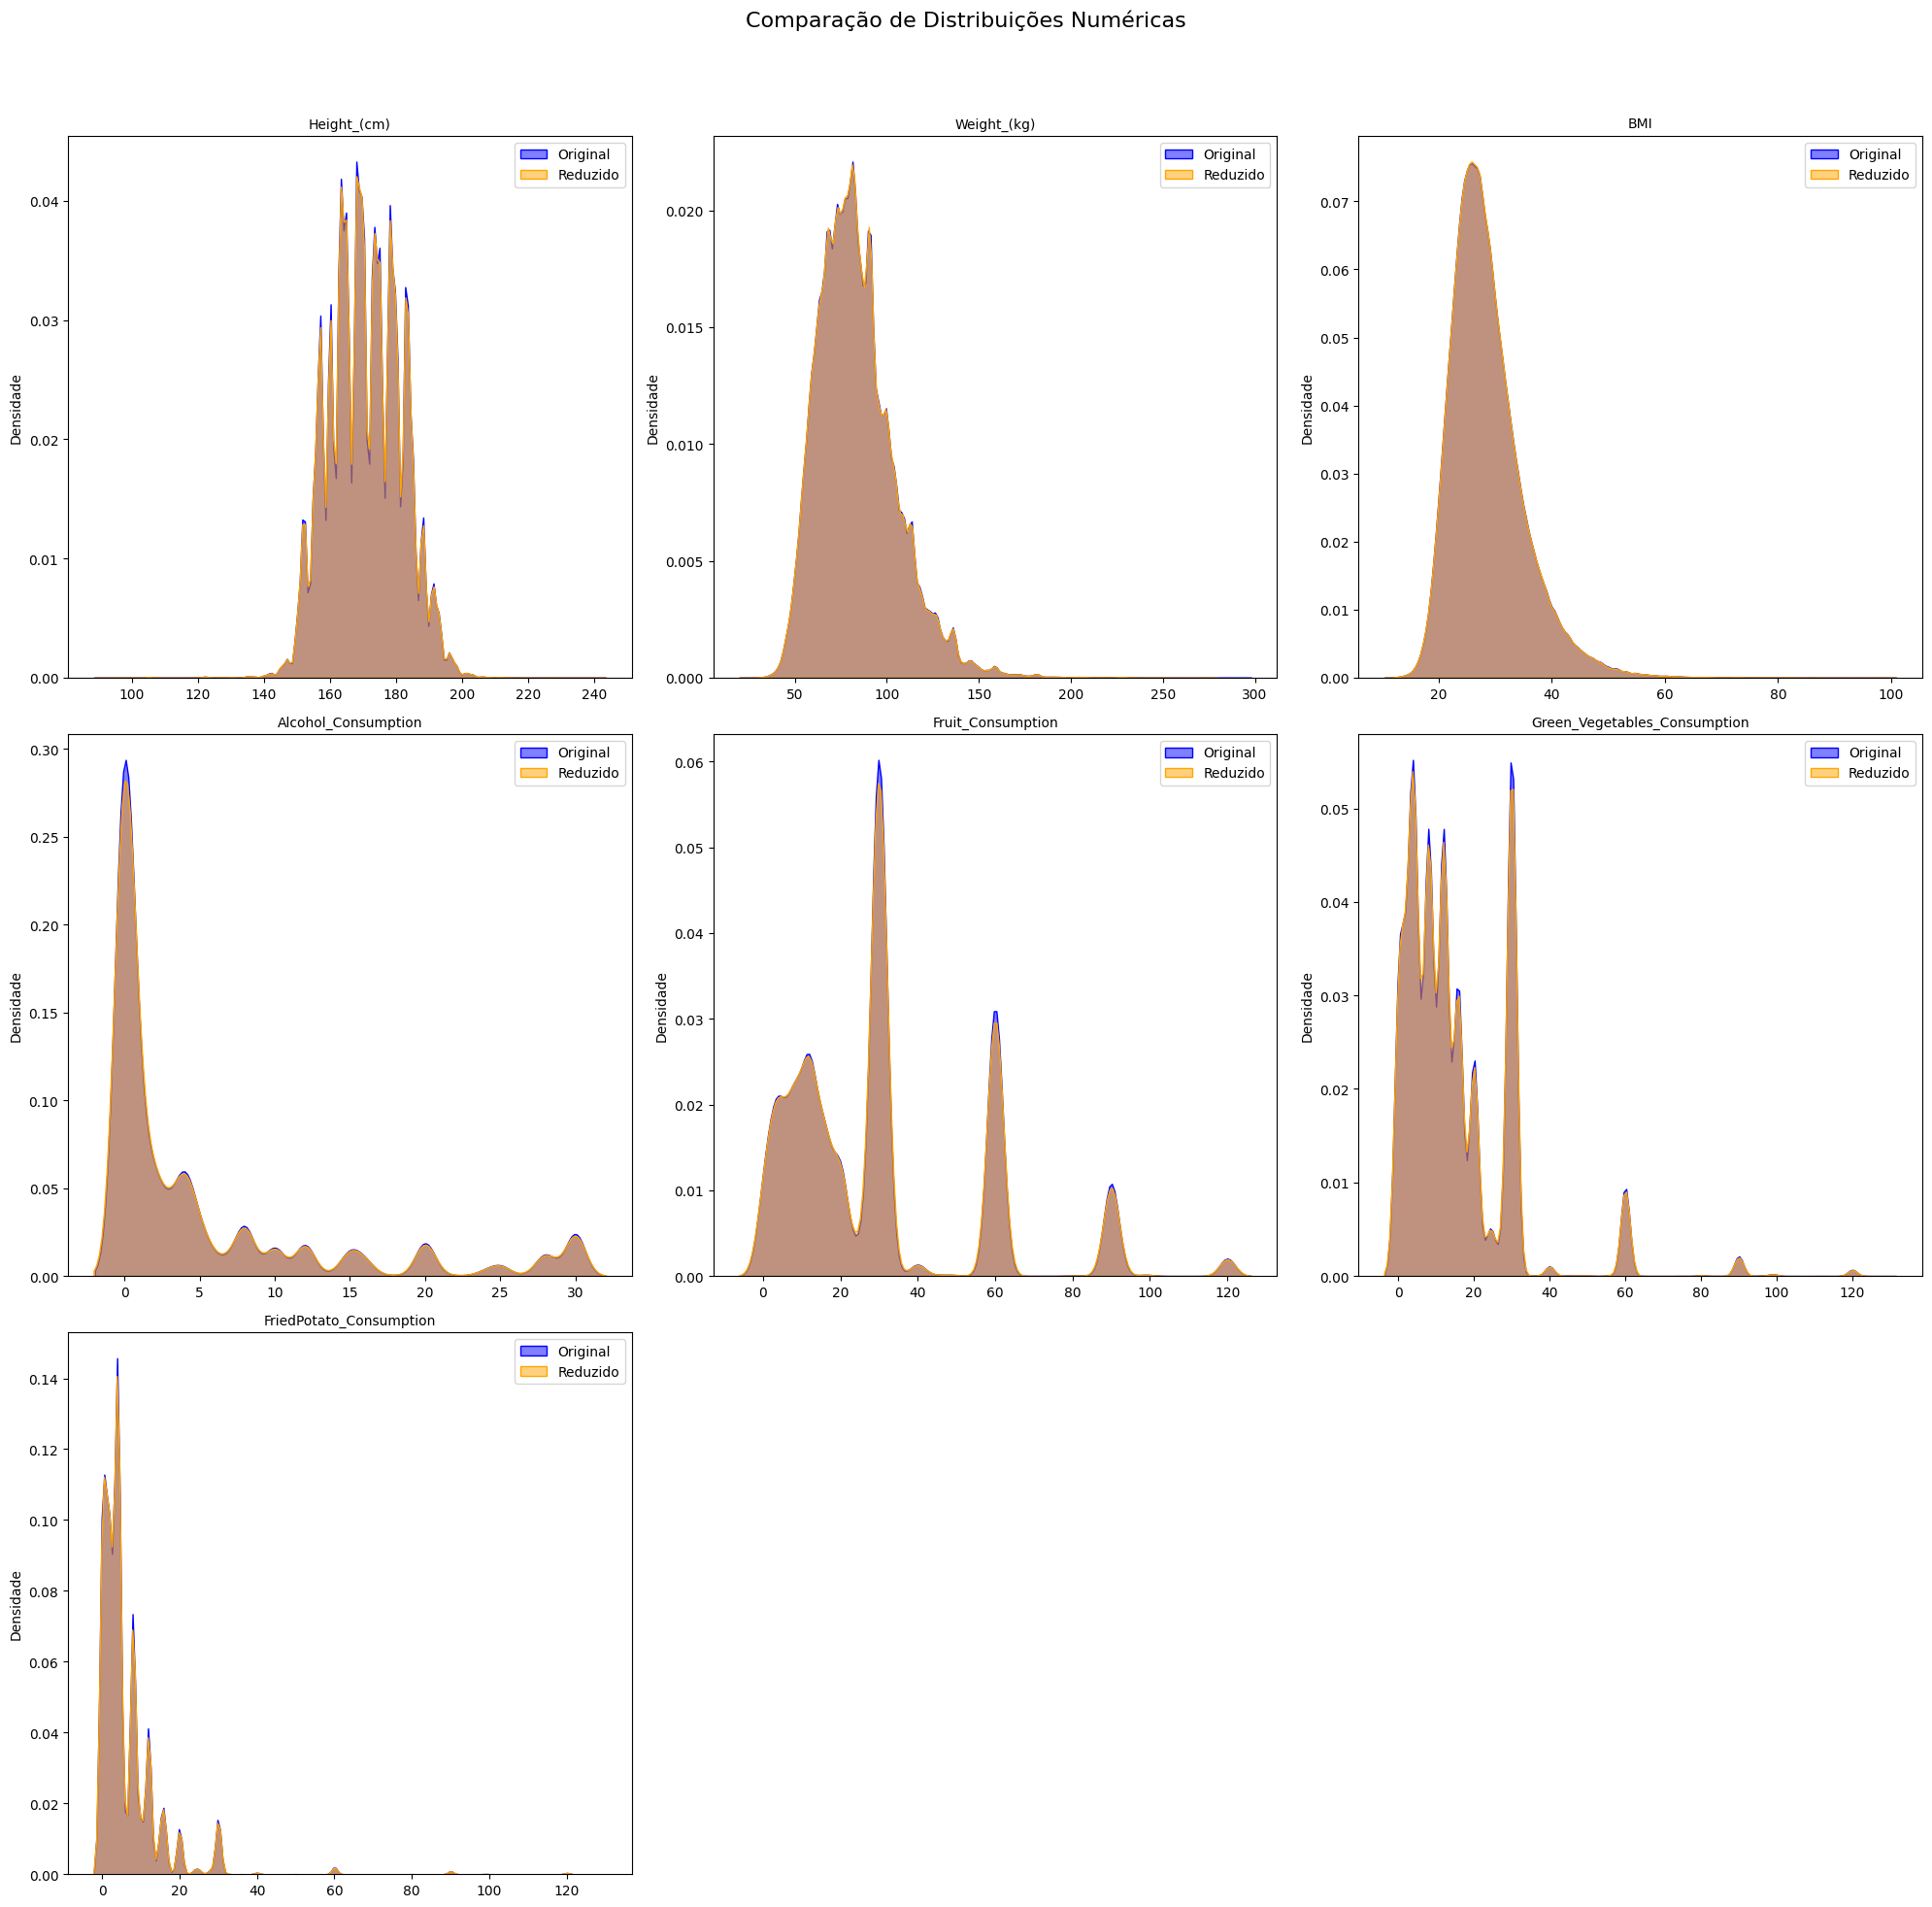

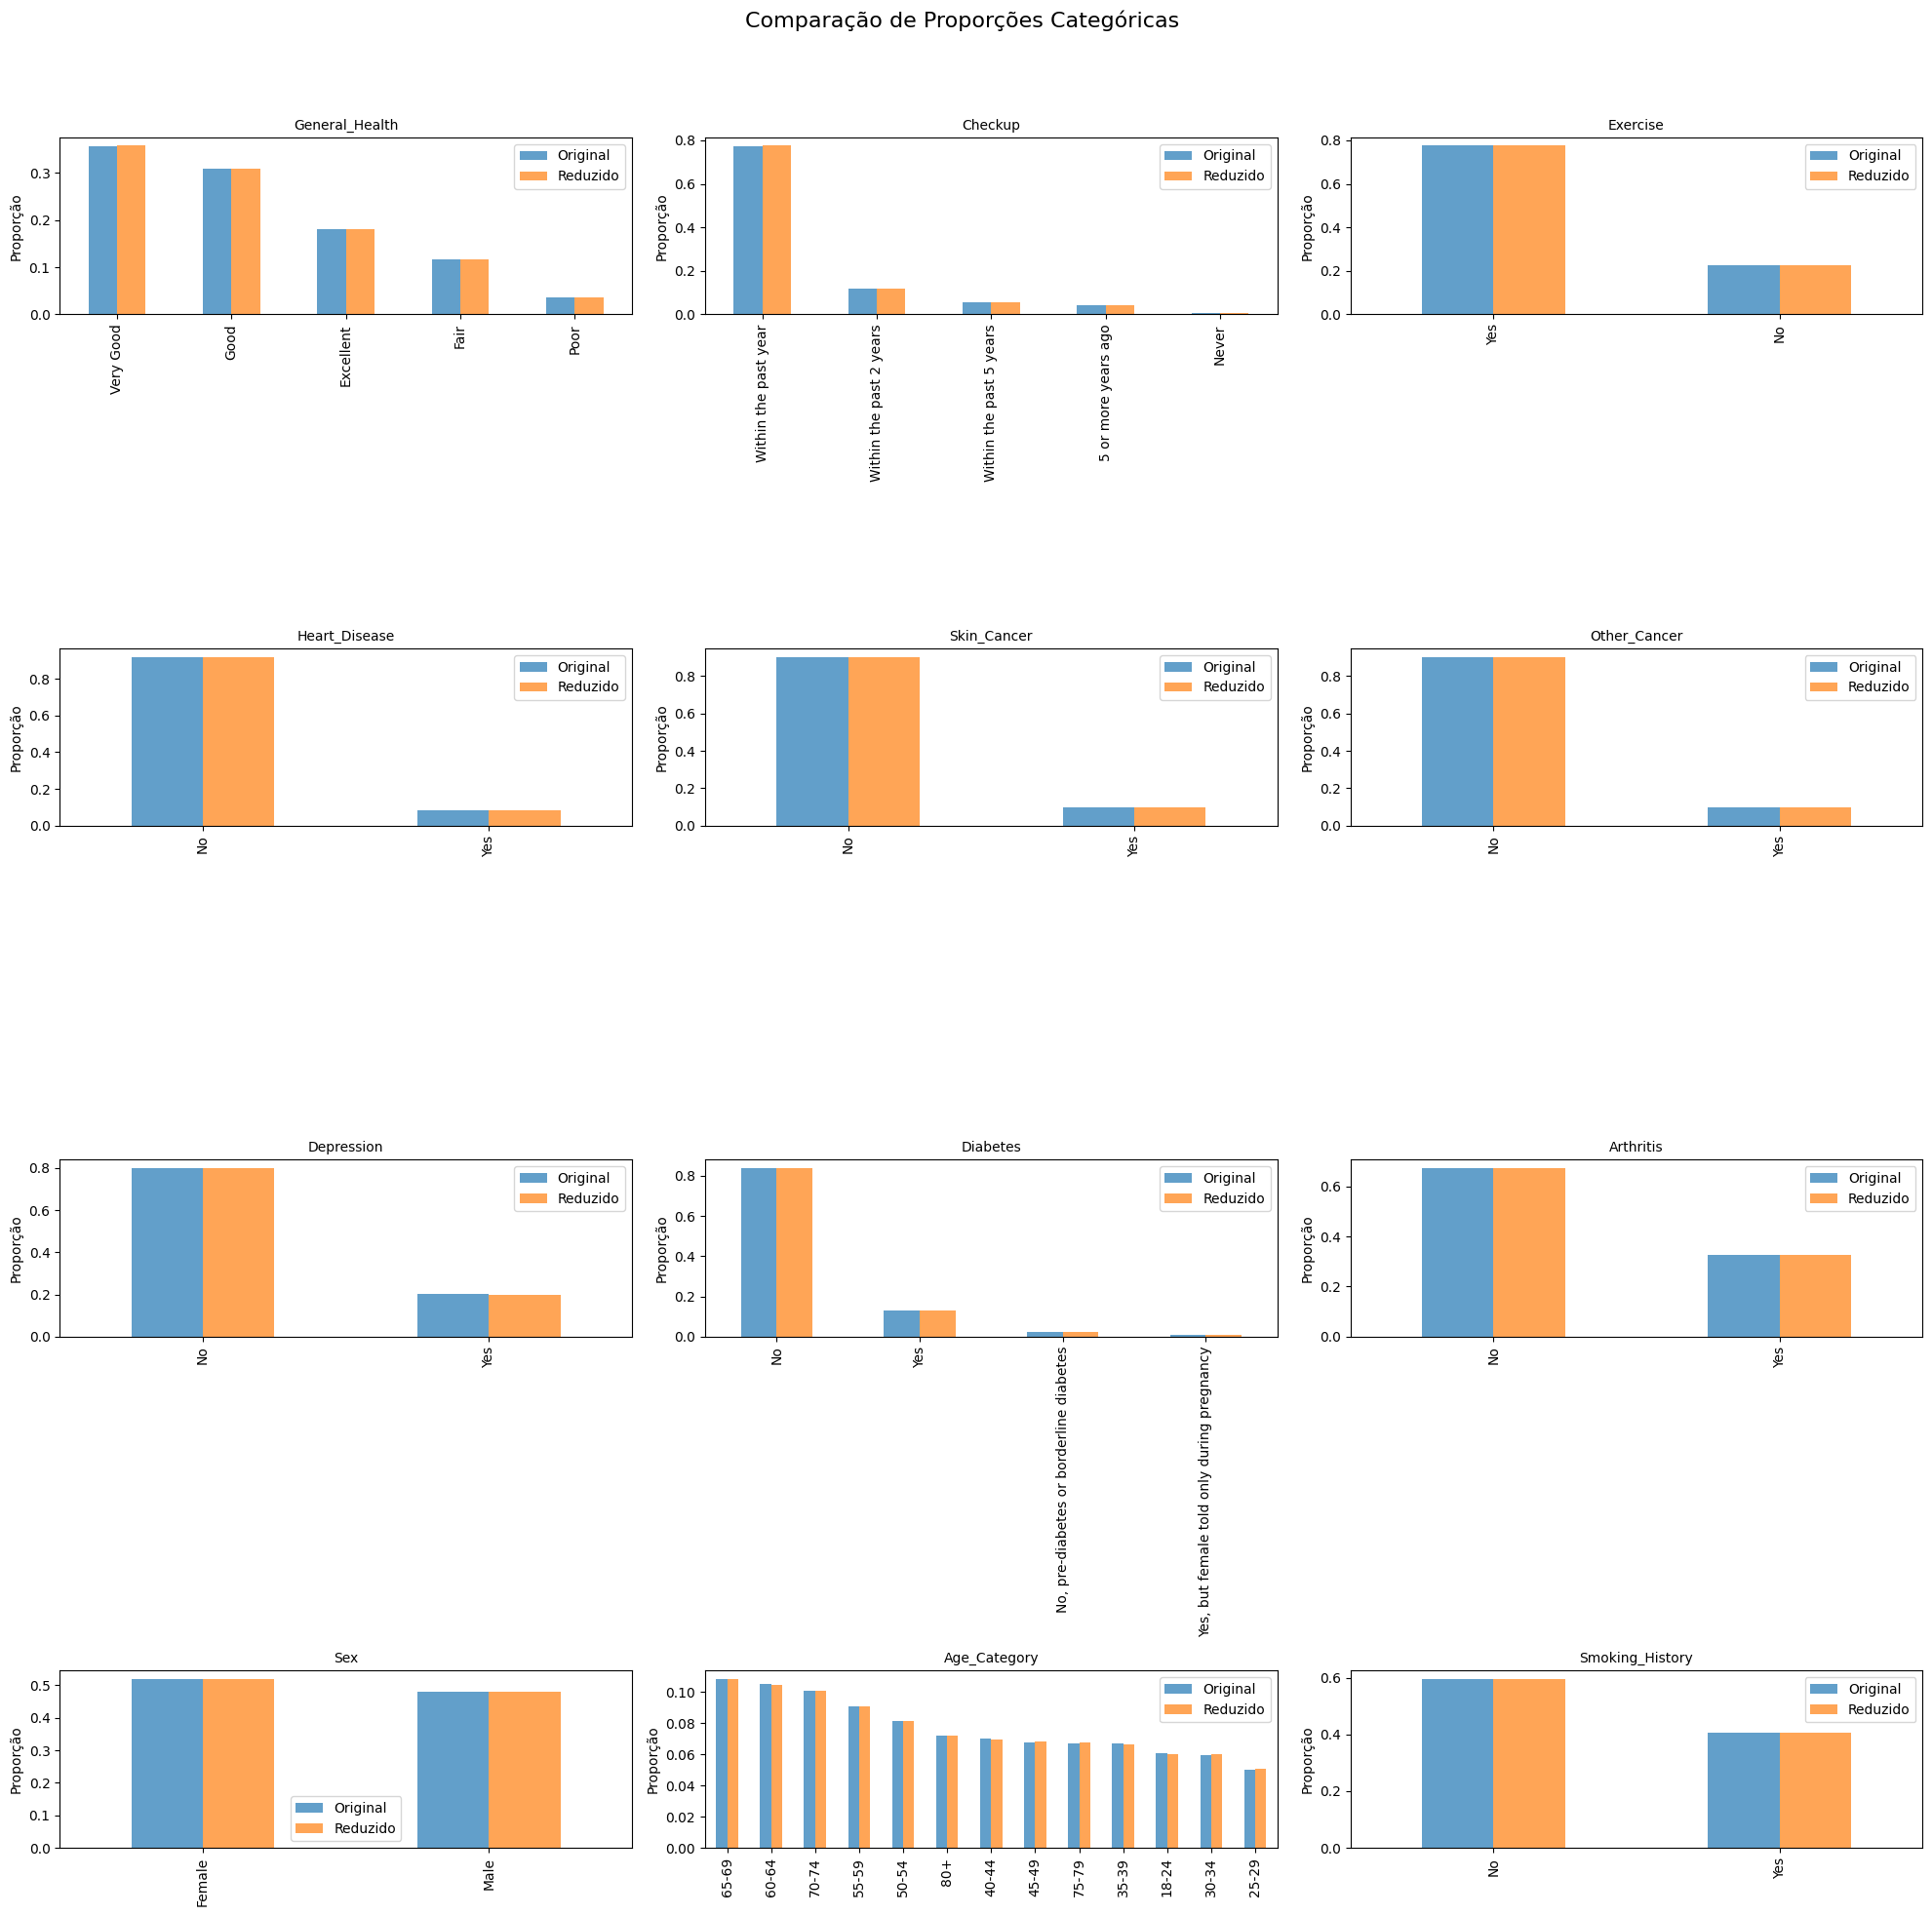

In [458]:
colunas_numericas = cvd_df.select_dtypes(include=['float64']).columns

comparar_distribuicoes_subplot(cvd_df, cvd_df_10reduced2, colunas_numericas)

colunas_categoricas = cvd_df.select_dtypes(include=['object']).columns

comparar_proporcoes_subplot(cvd_df, cvd_df_10reduced2, colunas_categoricas)

### Análise estatística do dataset reduzido em 10% pela estratégia 2


In [459]:
cvd_df_10reduced2.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,247109.000000,247109.000000,247109.000000,247109.000000,247109.000000,247109.000000,247109.000000
mean,170.599173,83.543039,28.615634,5.095124,29.834951,15.103044,6.289633
std,10.664606,21.308427,6.509788,8.200055,24.875958,14.912079,8.590716
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.780000,6.000000,30.000000,20.000000,8.000000
max,241.000000,274.420000,99.330000,30.000000,120.000000,128.000000,128.000000


Relativamente ao *dataset* original, a variação dos dados nas variáveis Height_(cm), Weight_(kg), BMI e Alcohol_Consumption houve uma diminuição ligeira nos valores do desvio padrão, revelando uma precisão ligeiramente superior. Para as variáveis Fruit_Consumption, Green_Vegetables_Consumption e FriedPotato_Consumption verificou-se o oposto.

### Dados ausentes do *dataset* reduzido em 20%

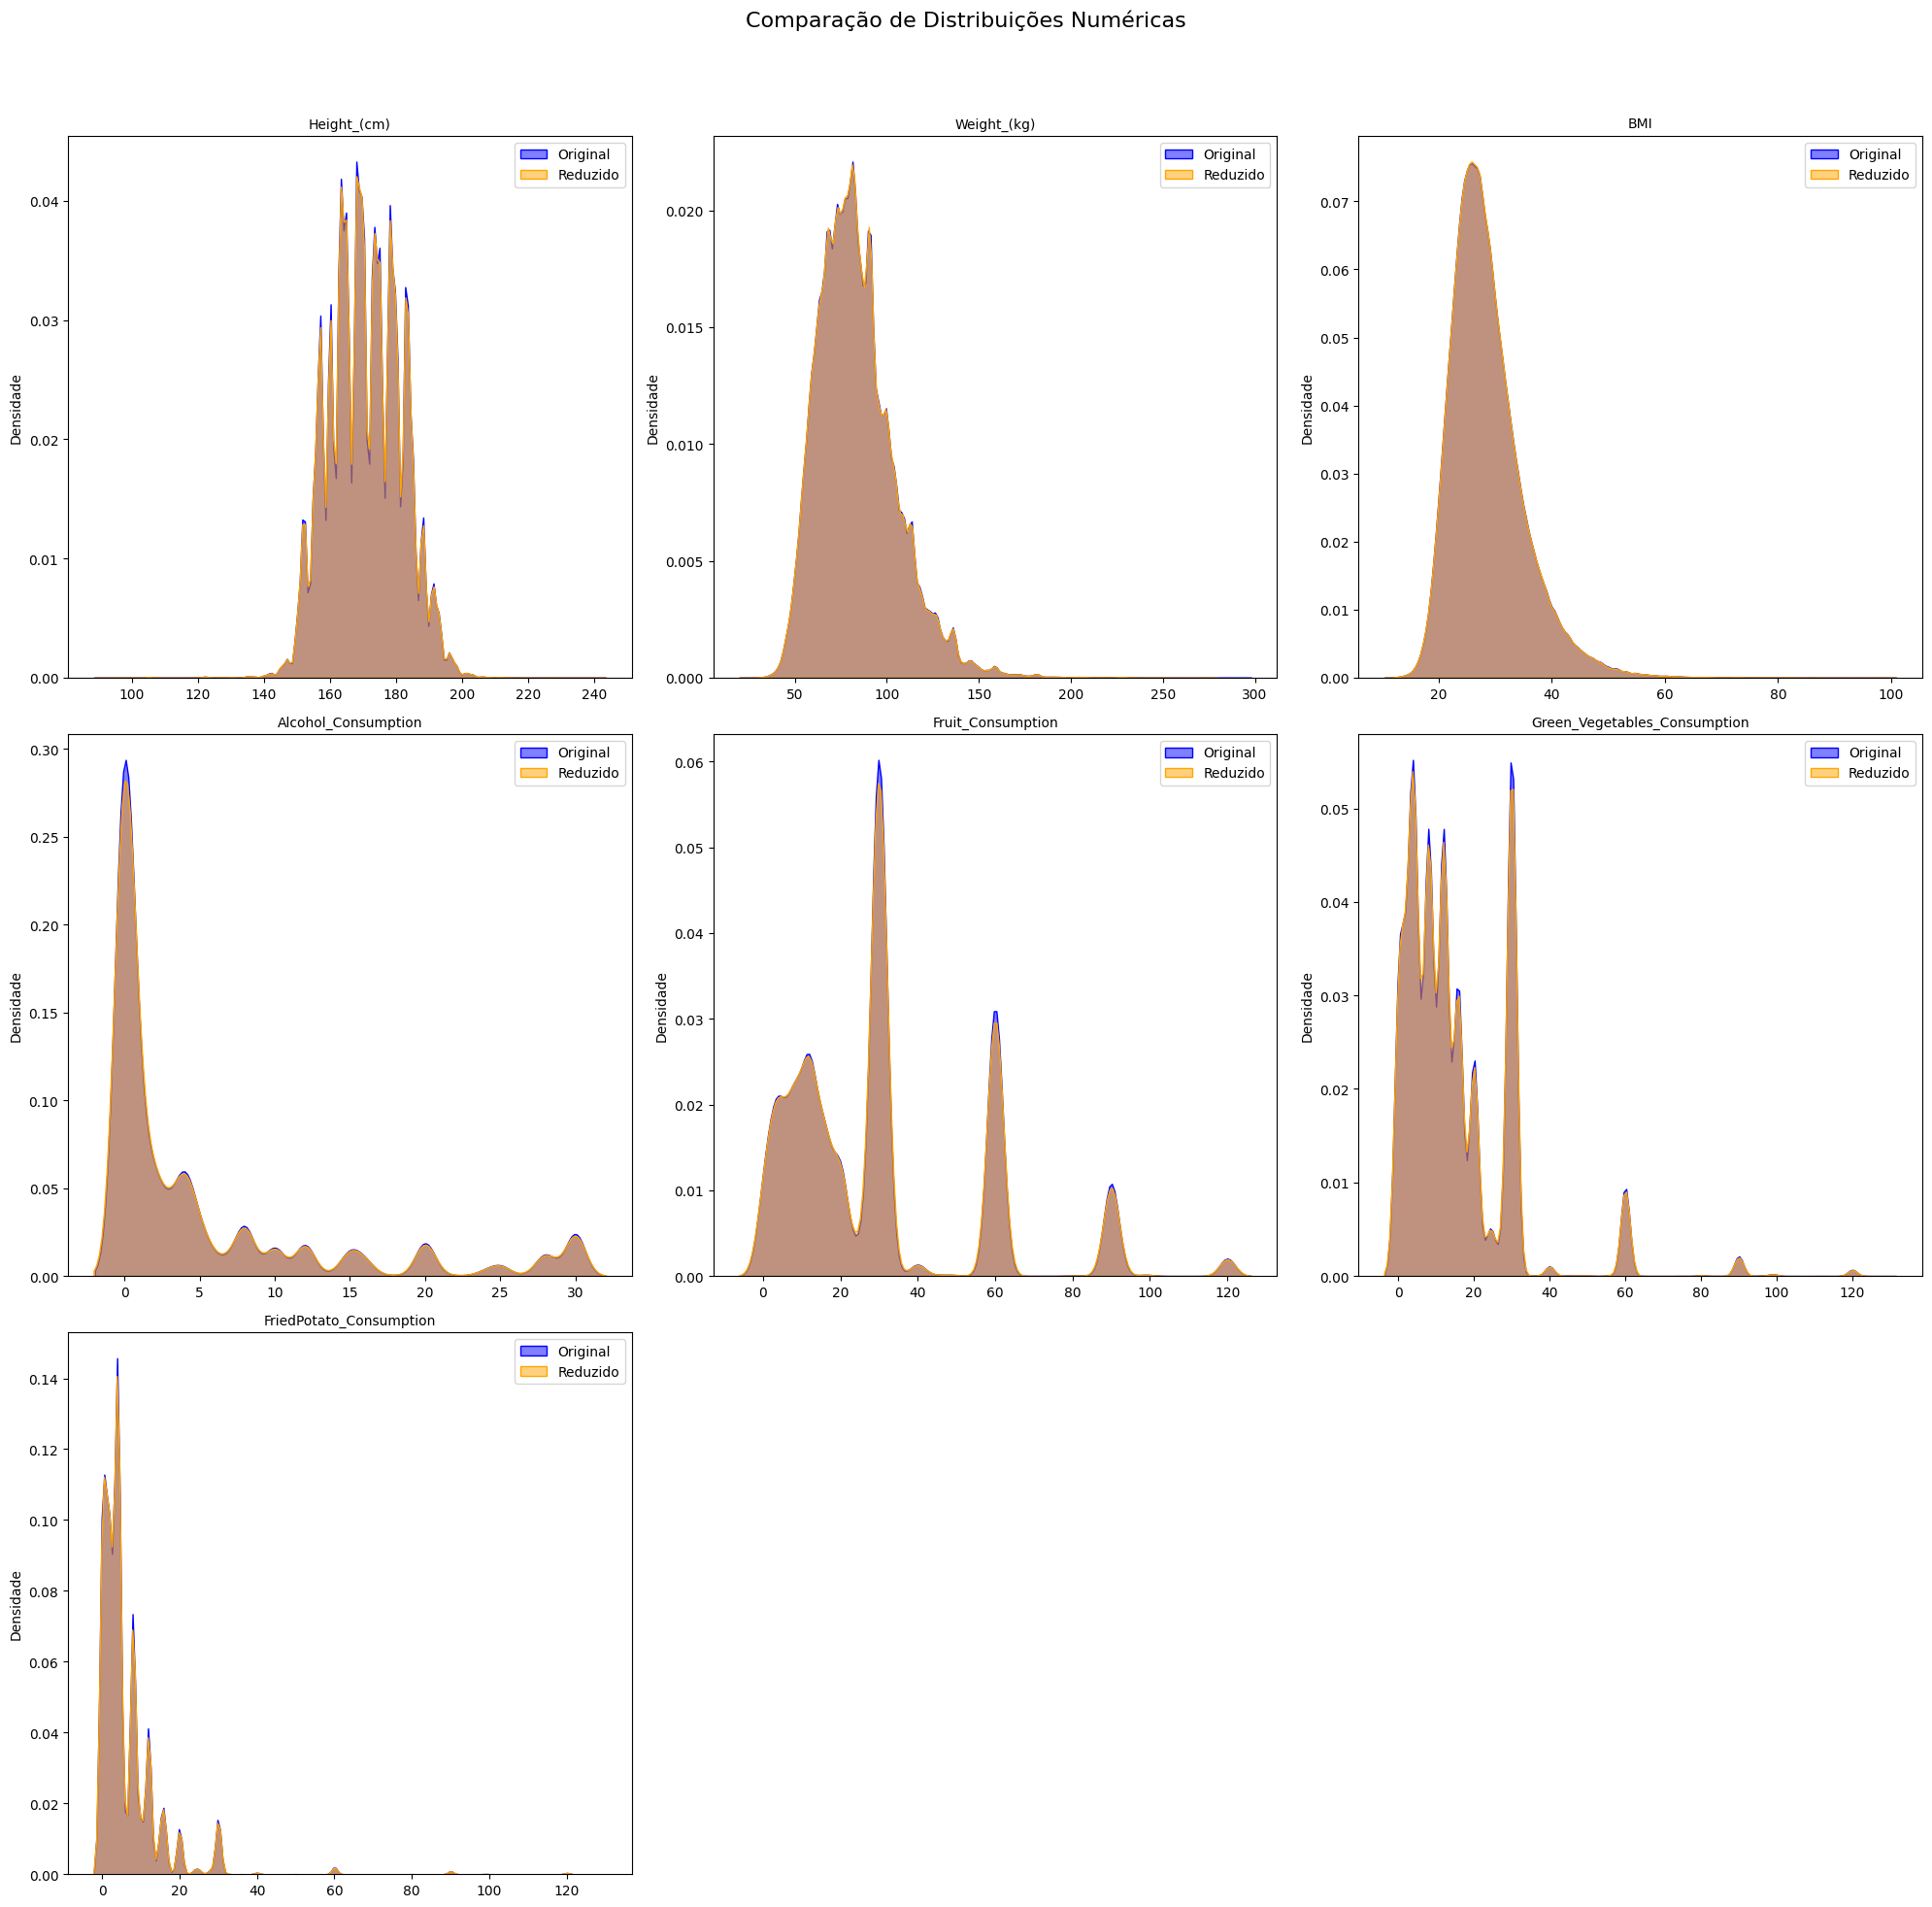

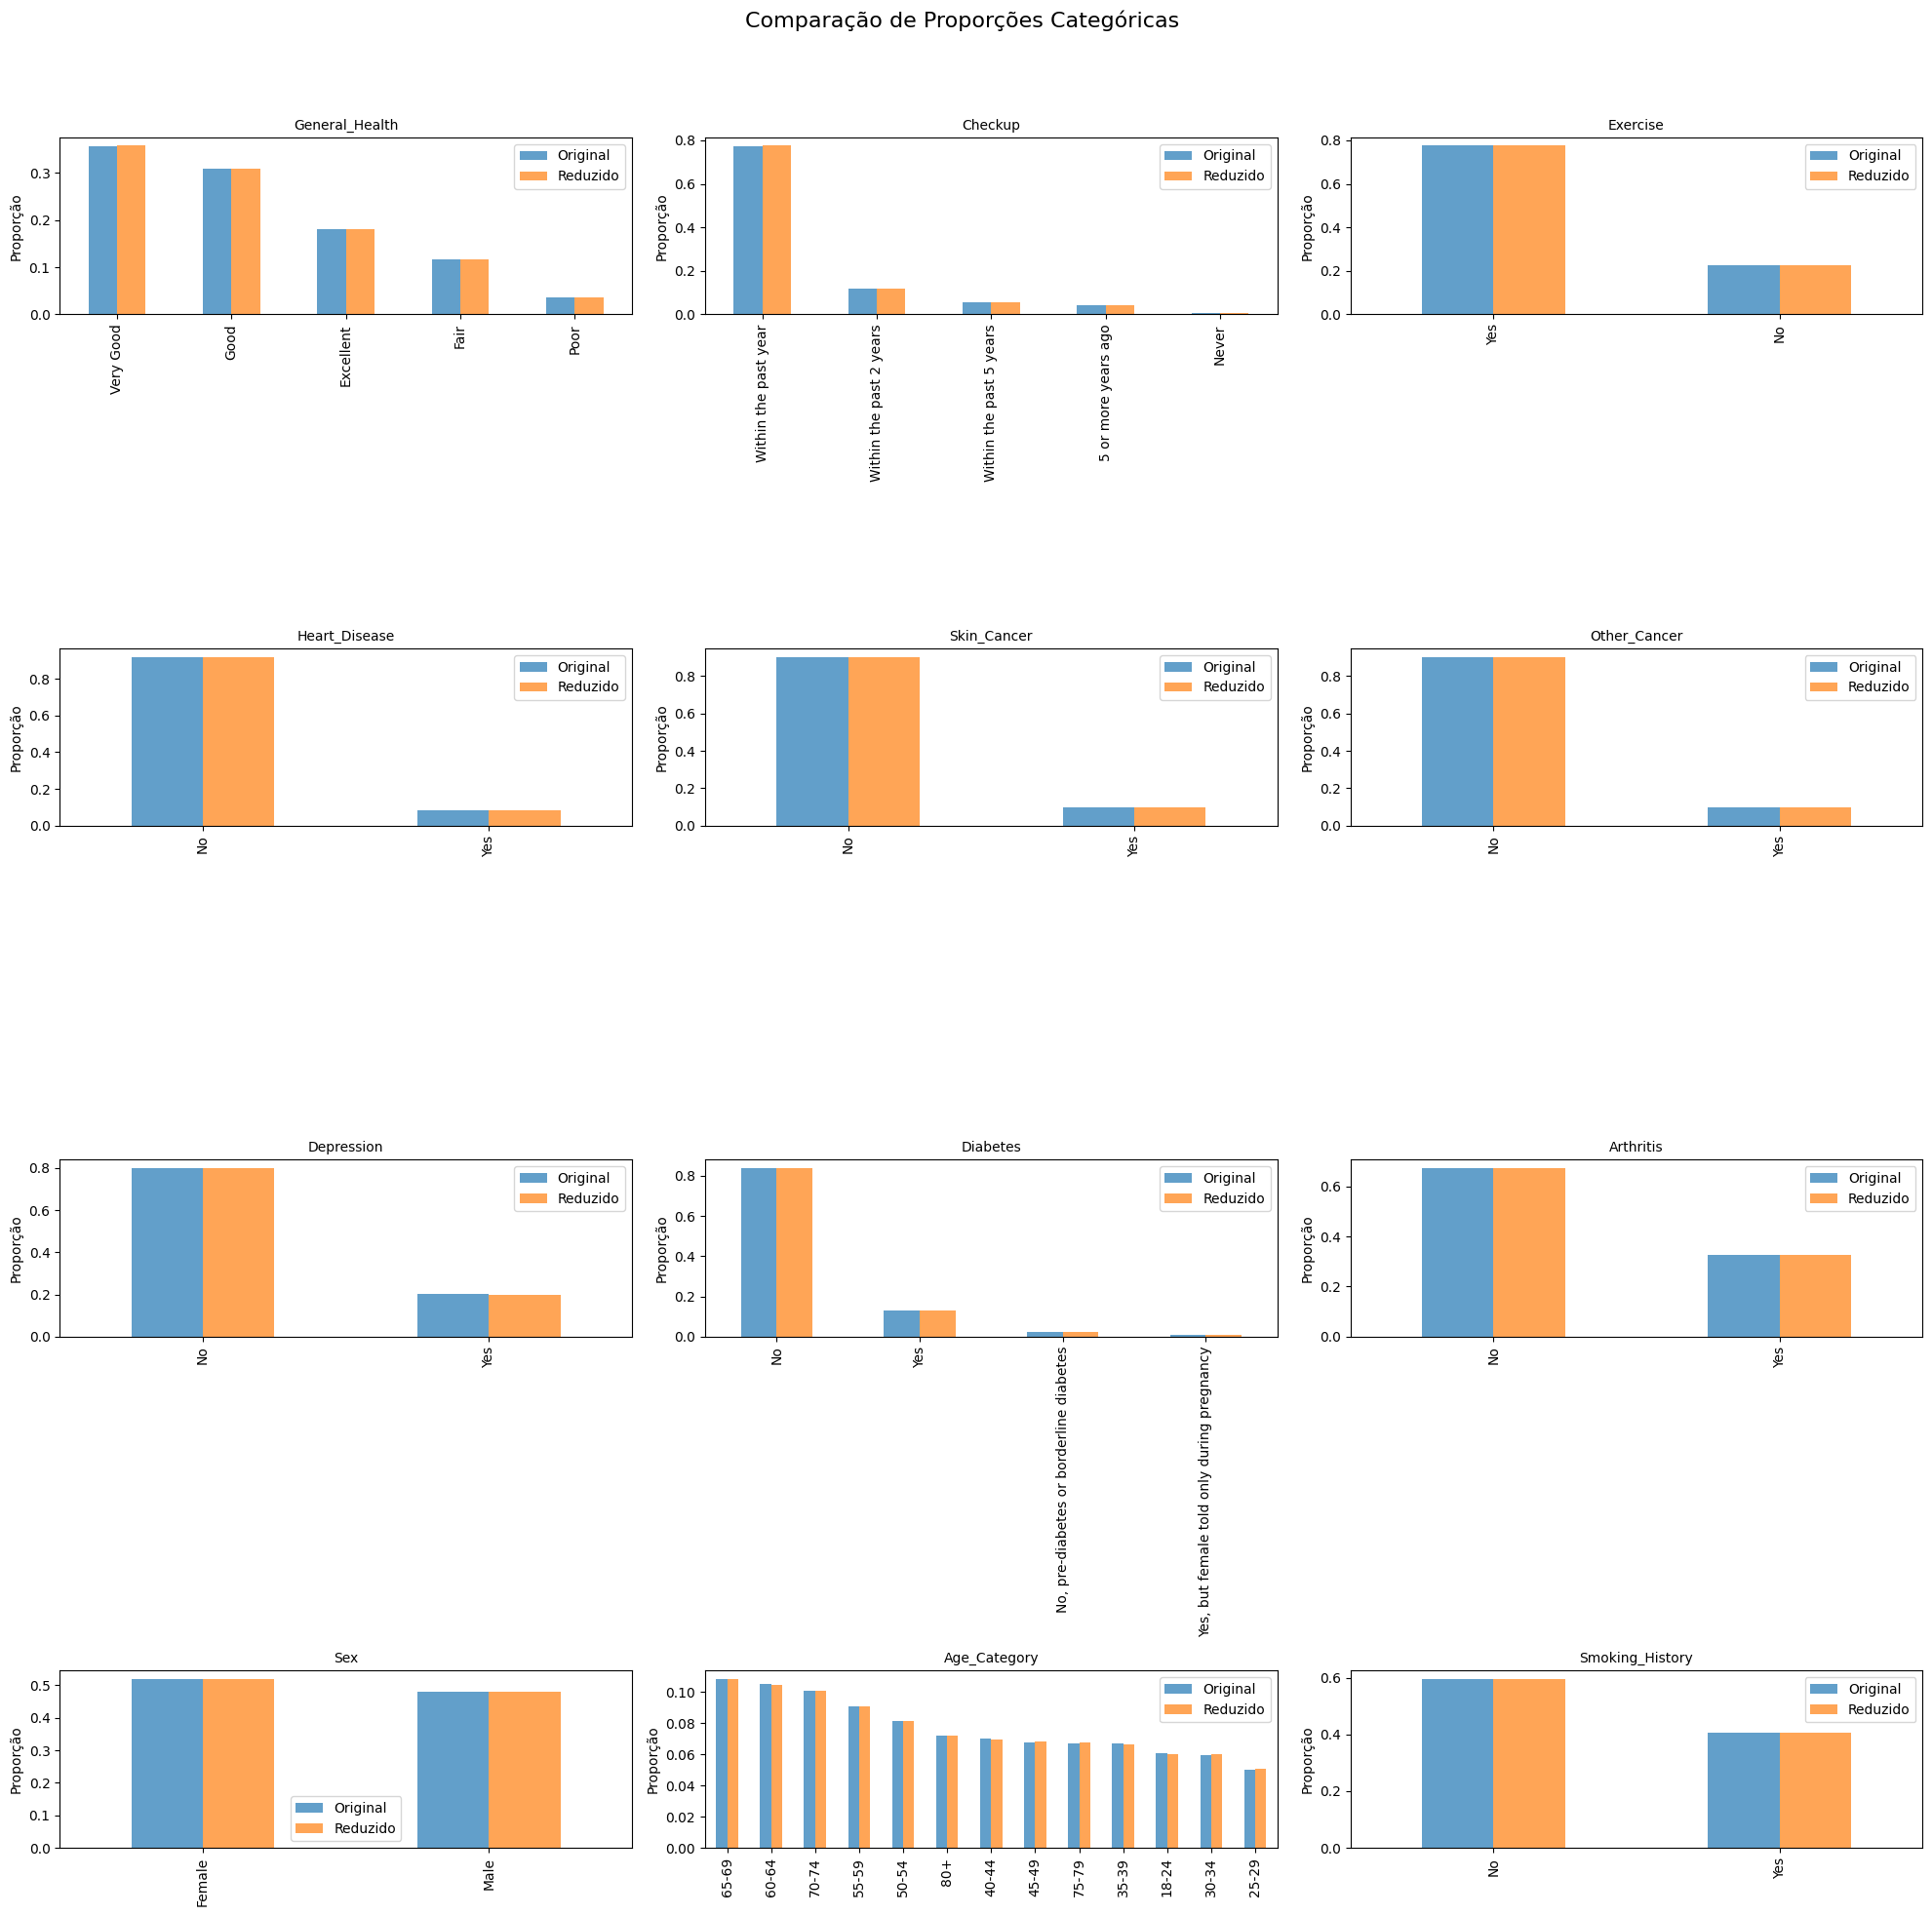

In [460]:
# Identificar índices das linhas ausentes no DataFrame reduzido
indices_removidos = pd.merge(
    cvd_df.assign(_original_index=cvd_df.index),
    cvd_df_20reduced,
    how="left",
    indicator=True
).query('_merge == "left_only"')['_original_index']


cvd_df_20reduced2 = cvd_df.drop(indices_removidos)

colunas_numericas = cvd_df.select_dtypes(include=['float64']).columns

comparar_distribuicoes_subplot(cvd_df, cvd_df_20reduced2, colunas_numericas)

colunas_categoricas = cvd_df.select_dtypes(include=['object']).columns

comparar_proporcoes_subplot(cvd_df, cvd_df_20reduced2, colunas_categoricas)

### Análise estatística do dataset reduzido em 20% pela estratégia 2


In [461]:
cvd_df_20reduced2.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,247109.000000,247109.000000,247109.000000,247109.000000,247109.000000,247109.000000,247109.000000
mean,170.599173,83.543039,28.615634,5.095124,29.834951,15.103044,6.289633
std,10.664606,21.308427,6.509788,8.200055,24.875958,14.912079,8.590716
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.780000,6.000000,30.000000,20.000000,8.000000
max,241.000000,274.420000,99.330000,30.000000,120.000000,128.000000,128.000000


# **Outliers**

In [462]:
# Função para remover outliers usando IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remover outliers de todas as colunas numéricas
cvd_df_processed = remove_outliers(cvd_df_10reduced, numerical_cols)

cvd_df_processed.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,148747.000000,148747.000000,148747.000000,148747.000000,148747.000000,148747.000000,148747.000000
mean,170.355577,81.785211,28.083257,2.696377,18.477603,11.933094,4.884818
std,10.375008,17.947271,5.196410,4.066817,10.892257,9.603260,4.252708
min,142.000000,31.750000,13.480000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.330000,0.000000,8.000000,4.000000,2.000000
50%,170.000000,81.650000,27.460000,0.000000,16.000000,10.000000,4.000000
75%,178.000000,92.990000,31.420000,4.000000,30.000000,16.000000,8.000000
max,200.000000,136.000000,42.090000,17.000000,56.000000,44.000000,17.000000


Usamos IQR para remover outliers das classes numéricas porque no Data Understanding visualizamos muitos outliers em várias classes.